In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import scipy.misc # load .mat files
import matplotlib.cm as cm # Used to display images in a specify colormap 
import random# to pick random images to display
import scipy.optimize # fmin_cg to train neural network
import itertools
from scipy.special import expit # sigmod

## 1 Neural setworks

### 1.1 Import datasets and visualizing 

In [3]:
dataFileName = "ex4data1.mat"
mat = scipy.io.loadmat(dataFileName)
X , y = mat["X"], mat["y"]
X.shape, y.shape

((5000, 400), (5000, 1))

In [7]:
X = np.insert(X, 0, 1, axis=1)

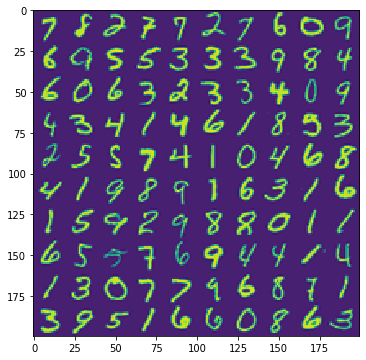

In [8]:
#将400 转为 20*20图像
def getImg(row):
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T

#展示图像
def displayImg(indices_to_display = None):
    width, height = 20, 20
    nrows, ncols = 10, 10
    if indices_to_display == None:
        indices_to_display = random.sample(range(X.shape[0]), nrows * ncols)
    big_picture = np.zeros((height * nrows, width * ncols))
    irow , icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol = 0
        iimg = getImg(X[idx])
        big_picture[(irow * height):(irow * height + iimg.shape[0]),
                   (icol * width):(icol * width +iimg.shape[1])] = iimg
        icol += 1
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(big_picture,interpolation='nearest')
displayImg()

### 1.2 Model representation


In [10]:
dataFileName = "ex4weights.mat"
mat = scipy.io.loadmat(dataFileName)
Theta1, Theta2 = mat["Theta1"], mat["Theta2"]
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [11]:
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10
n_training_samples = X.shape[0]

In [34]:
# make X to be and column vector
def flattenX(X):
    return X.reshape((n_training_samples * (input_layer_size + 1), 1)) # (2005000,)
# reshape X to be matrix
def reshapeX(flattenedX):
    return flattenedX.reshape((n_training_samples, input_layer_size + 1))# (5000, 401)

def flattenParams(thetas_list):
    flattened_list = [theta.flatten() for theta in thetas_list]
    combined = list(itertools.chain.from_iterable(flattened_list))
    return np.array(combined).flatten() #(10285,)
def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size + 1) * hidden_layer_size] \
            .reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = flattened_array[(input_layer_size + 1) * hidden_layer_size:] \
            .reshape((output_layer_size, hidden_layer_size + 1))
    return [theta1, theta2] # (25, 401) and (10, 26)

### 1.3 Feedforward and cost function

In [36]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

In [75]:
def propagateForward(row, #  one training example (401,)
                     Thetas): # (25, 401) (10, 26)
    m = row.shape[0]
    a1 = row.copy() # (401,)
    z2 = Thetas[0].dot(row) # (25, 401) @ (401,) = (25,)  
    a2 = np.insert(sigmod(z2), 0, 1, axis=0) # (26,)
    z3 = Thetas[1].dot(a2) # (10, 26) @ (26,) = (10,)
    h = sigmod(z3) #(10,)
    return a1, z2, a2, z3, h

def computeCost(flattened_thetas, #(10285,) include bias unit
            flattened_X, # (2005000,) include the bias unit
            y, # 
            mylambda=0.):
    mythetas = reshapeParams(flattened_thetas)
    myX = reshapeX(flattened_X)
    total_cost = 0.
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        *t, myhs = propagateForward(myX[irow], mythetas)
        # build an one-hot vector
        tempy = np.zeros((10, 1))
        tempy[y[irow] - 1] = 1
        
        tempcost = -tempy.T @ np.log(myhs) - (1 - tempy).T @ np.log(1 - myhs) # (1,)
        
        total_cost += tempcost[0]
    
    total_cost /= m
    
    total_reg = 0.
    for theta in mythetas:
        total_reg += np.sum(theta * theta) # use multiply not dot
    total_reg *= float(mylambda) / (2 * m)
    return float(total_cost + total_reg)
# a1, z2, a2, z3, h = propagateForward(X[0], [Theta1, Theta2])
computeCost(flattenThetas([Theta1, Theta2]), flattenX(X), y)

0.28762916516131876

### 1.4 Regularized cost function

In [76]:
computeCost(flattenThetas([Theta1, Theta2]), flattenX(X), y, 1.)

0.3844877962428938

## 2 Backpropagation

### 2.1 Sigmod gradient

In [77]:
def sigmodGradient(z):
    temp = sigmod(z)
    return temp * (1 - temp)

### 2.2 Random initialization

In [186]:
def getRandThetas():
#     return [np.random.rand(hidden_layer_size, input_layer_size + 1), 
#             np.random.rand(output_layer_size, hidden_layer_size + 1)]
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

### 2.3 Backpropagation

In [187]:
def backPropagate(flattened_thetas, flattened_X, y, mylam=0.):
    thetas = reshapeParams(flattened_thetas) #(25, 401) (10, 26)
    myX = reshapeX(flattened_X)
    
    #the shape of derivative matrix is same as the thetas matrix
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1))
    D2 = np.zeros((output_layer_size, hidden_layer_size + 1))
    
    m = n_training_samples
    for i in range(m):
        row = myX[i]
        a1, z2, a2, z3, h = propagateForward(row, thetas)
        tmpy = np.zeros((10,1))
        tmpy[y[i] - 1] = 1
        
        d3 = h.reshape((10, 1)) - tmpy 

        #  thetas[1] : (10, 26) d3 (10, 1) z2: (25,)
        tdet = thetas[1].T[1:, :]
        
#         print(tdet.shape, d3.shape, z2.shape)
        d2 = (thetas[1].T)[1:, :] @ d3 * sigmodGradient(z2).reshape((25, 1)) # (10, 1)
        # the a of bias unit is 1, so we can use d @ a
#         print(type(d2), type(a1.T))
        D1 += d2 @ a1.T.reshape(1, 401) # (25, 1) @ (1, 401) = (25, 401)
#         D2 += 
        D2 += d3 @ a2.T.reshape(1, 26) # (10, 1) @ (1, 26) = (10, 26)
    
    D1 /= m
    
    D1[:, 1:] += (float(mylam) / m) * thetas[0][:, 1:]
    D2[:, 1:] += (float(mylam) / m) * thetas[1][:, 1:]
    return flattened_thetas


In [188]:
flattened_D =  backPropagate(flattenParams([Theta1, Theta2]), flattenX(X), y)
D1, D2 = reshapeParams(flattened_D)
D1.shape, D2.shape

((25, 401), (10, 26))

### 2.4 Gradient checking

In [189]:
def checkGradient(thetas, Ds, X, y, lam=0.):
    eps = 1e-4
    flattened_thetas = flattenParams(thetas)
    flattened_D = flattenParams(Ds)
    flattened_X = flattenX(X)
    n_elems = len(flattened_thetas)
    print(flattened_thetas.shape)
    # pick ten random elements, compute numerical gradient, compare to respacetive D's
    for i in range(10):
        x = int(np.random.rand() * n_elems)
        epsvec = np.zeros(n_elems)
        epsvec[x] = eps
        cost_high = computeCost(flattened_thetas + epsvec, flattened_X, y, lam)
        cost_low = computeCost(flattened_thetas - epsvec, flattened_X, y, lam)
        mygrad = (cost_high - cost_low) / ( 2 * eps)
        print("Element: %d. Numerical Gradient = %f. Backprop Gradient = %f. "%(x, mygrad, flattened_D[x]))
checkGradient([Theta1, Theta2], [D1, D2], X, y)

(10285,)
Element: 9437. Numerical Gradient = 0.000125. Backprop Gradient = -0.389048. 
Element: 9261. Numerical Gradient = 0.000001. Backprop Gradient = -0.002452. 
Element: 4987. Numerical Gradient = -0.000239. Backprop Gradient = 0.406028. 
Element: 754. Numerical Gradient = 0.000058. Backprop Gradient = -0.115753. 
Element: 7004. Numerical Gradient = 0.000405. Backprop Gradient = -0.608074. 
Element: 927. Numerical Gradient = 0.000051. Backprop Gradient = -0.102837. 
Element: 7947. Numerical Gradient = -0.000217. Backprop Gradient = 0.350569. 
Element: 9647. Numerical Gradient = -0.000000. Backprop Gradient = 0.000090. 
Element: 7844. Numerical Gradient = 0.000339. Backprop Gradient = -0.590772. 
Element: 5395. Numerical Gradient = 0.000010. Backprop Gradient = -0.014895. 


In [178]:
checkGradient([Theta1, Theta2], [D1, D2], X, y, 0.02)

(10285,)
Element: 7197. Numerical Gradient = 0.000000. Backprop Gradient = -0.000021. 
Element: 8580. Numerical Gradient = -0.000155. Backprop Gradient = 0.257953. 
Element: 4086. Numerical Gradient = 0.000133. Backprop Gradient = -0.211820. 
Element: 5681. Numerical Gradient = 0.000042. Backprop Gradient = -0.077161. 
Element: 2826. Numerical Gradient = -0.000000. Backprop Gradient = 0.000000. 
Element: 8587. Numerical Gradient = -0.000127. Backprop Gradient = 0.265044. 
Element: 5417. Numerical Gradient = -0.000156. Backprop Gradient = 0.178128. 
Element: 6896. Numerical Gradient = 0.000021. Backprop Gradient = -0.034650. 
Element: 15. Numerical Gradient = -0.000000. Backprop Gradient = 0.000412. 
Element: 3440. Numerical Gradient = 0.000318. Backprop Gradient = -0.462223. 


### Learning paramters using fmincg

In [190]:
def trainNN(lam = 0.):
    
    randomThetas_unrolled = flattenParams(getRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                                   args=(flattenX(X), y, lam), maxiter=50, disp=True, full_output=True)
    return result[0]

In [191]:
learned_thetas = trainNN()

Optimization terminated successfully.
         Current function value: 6.931472
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11


In [192]:
def predictNN(row, Thetas):
    classes = range(1, 11)
    output = propagateForward(row, Thetas)
    return classes[np.argmax(output[-1])]
def computeAccuracy(X, Thetas, y):
    n_correct, n_total = 0, X.shape[0]
    for i in range(n_total):
        if int(predictNN(X[i], Thetas)) == int(y[i]):
            n_correct += 1
    
    print("Training set accuracy: %0.1f%%"%(100 * float(n_correct) / n_total))

In [193]:
computeAccuracy(X, reshapeParams(learned_thetas), y)

Training set accuracy: 10.0%


In [194]:
a + c.reshape((10,1))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])